In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [20]:
#constantes
mu0 = 1.2566370612e-6 #N/A^2
pi = np.pi

In [21]:
def J1(A, B, C):
    return (C - B) / np.sqrt(A - 2 * B + C)

def J2(A, B, C):
    return B / np.sqrt(A)

def J3(A, B, C):
    return np.log((np.sqrt(A - 2 * B + C) + np.sqrt(C)) / (np.sqrt(A) + np.sqrt(C)))

def J4(A, B, C):
    return (1 / np.sqrt(C)) * (np.arctan((np.sqrt(A) - B) / np.sqrt(C)) + np.arctan(B / np.sqrt(C)))

class CurrentSheet:
    def __init__(self, ra, rb, p, current=1):
        self.ra = ra
        self.rb = rb
        self.p = p
        self.pnorm = pnorm = np.linalg.norm(p)
        self.current = current
        self.current_density = current/pnorm
        #calculate the normal which is perpendicular to rb-ra and p
        normal = np.cross(rb-ra, p)
        self.normal = normal/np.linalg.norm(normal)
    def B(self, r):
        #load constants
        ra, rb, p, Iprime = self.ra, self.rb, self.p, self.current_density
        A = np.dot(r - ra, r - ra)
        B = np.dot(r - ra, rb - ra)
        C = np.dot(rb - ra, rb - ra)

        k = mu0 * Iprime / (4 * np.pi)
        v = np.cross(rb - ra, r - ra)
        denom = np.dot(A, C) - np.dot(B, B)

        if abs(denom) < 1e-10:  # Avoid division by zero
            return np.array([0.0, 0.0, 0.0])

        return k * (J1(A, B, C) + J2(A, B, C)) * v / denom  # Adjusted formula)
    @property
    def outline(self):
        p, ra,rb = self.p, self.ra, self.rb
        return np.array([ra+p, rb+p, rb-p, ra-p, ra+p])

[[ 2.88675135e-08 -2.88675135e-08  0.00000000e+00]
 [ 2.94551679e-08 -3.16370322e-08  0.00000000e+00]
 [ 2.98592047e-08 -3.46366775e-08  0.00000000e+00]
 ...
 [-2.98592047e-08  3.46366775e-08  0.00000000e+00]
 [-2.94551679e-08  3.16370322e-08  0.00000000e+00]
 [-2.88675135e-08  2.88675135e-08  0.00000000e+00]]


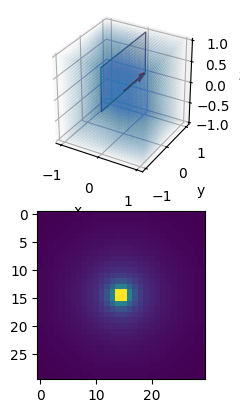

In [60]:
# Create a current sheet
ra = np.array([0, 0, 0])
rb = np.array([0, 0, 1])
p = np.array([0, 1, 0])
current_sheet = CurrentSheet(ra, rb, p)

# Plot the current sheet outline in 3D as full plane
outline = current_sheet.outline
fig = plt.figure()
ax = fig.add_subplot(2,1,1, projection='3d')

verts = [current_sheet.outline[:-1]]
rect = Poly3DCollection(verts, facecolors="#67597A", edgecolors='#67597A', alpha=0.2)
ax.add_collection3d(rect)

ax.quiver(*ra, *(p), color='r')
# Create and add the polygon
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#set axes equal
ax.set_box_aspect([1,1,1])

#plot the magnetic field
N=30
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
z = np.linspace(-1, 1, N)
X, Y, Z = np.meshgrid(x, y, z)
B = np.array([current_sheet.B(np.array([x, y, z])) for x, y, z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))])

Bx = B[:, 0]
By = B[:, 1]
Bz = B[:, 2]

plt.quiver(np.ravel(X), np.ravel(Y), np.ravel(Z), Bx, By, Bz, length=0.1, normalize=True,alpha=0.02)

ax2 = fig.add_subplot(2,1,2)
cmap = plt.get_cmap('viridis')
#plot magnetic field intensity for Z = 0
B = np.array([current_sheet.B(np.array([i, j, 0])) for i in x for j in y])
print(B)
#use np.linalg.norm to calculate the intensity of the magnetic field
B = np.array([np.linalg.norm(b) for b in B])
B = B.reshape(N, N)


plt.imshow(B, cmap=cmap)

plt.show()